# IMPORT LIB

In [1]:
from multiprocessing import Pool
from matplotlib import pyplot as plt
from numba import njit
import numpy as np
import pandas as pd
import random
from datetime import datetime as date
from pandas._libs.tslibs.np_datetime import OutOfBoundsDatetime
from scipy.optimize import minimize
from tqdm import tqdm
import xarray as xr
from datetime import datetime as dt
%matplotlib inline

# **Log-Periodic Power Law Model LPPLS**

In [2]:
class LPPLS(object):

    def __init__(self, observations):
        """
        Args:
            observations (np.array,pd.DataFrame): 2xM matrix with timestamp and observed value.
        """
        assert isinstance(observations, (np.ndarray, pd.DataFrame)), \
            f'Expected observations to be <pd.DataFrame> or <np.ndarray>, got :{type(observations)}'

        self.observations = observations
        self.coef_ = {}
        self.indicator_result = []

    @staticmethod
    @njit
    def lppls(t, tc, m, w, a, b, c1, c2):
        return a + np.power(tc - t, m) * (b + ((c1 * np.cos(w * np.log(tc - t))) + (c2 * np.sin(w * np.log(tc - t)))))

    def func_restricted(self, x, *args):
        """
        Finds the least square difference.
        See https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
        Args:
            x(np.ndarray):  1-D array with shape (n,).
            args:           Tuple of the fixed parameters needed to completely specify the function.
        Returns:
            (float)
        """

        tc = x[0]
        m = x[1]
        w = x[2]
        observations = args[0]

        rM = self.matrix_equation(observations, tc, m, w)
        a, b, c1, c2 = rM[:, 0].tolist()
        # print('type', type(res))
        # print('func_restricted', res)

        delta = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in observations[0, :]]
        delta = np.subtract(delta, observations[1, :])
        delta = np.power(delta, 2)

        return np.sum(delta)

    @staticmethod
    @njit
    def matrix_equation(observations, tc, m, w):
        """
        Derive linear parameters in LPPLs from nonlinear ones.
        """
        T = observations[0]
        P = observations[1]
        N = len(T)

        # @TODO make taking tc - t or |tc - t| configurable
        dT = np.abs(tc - T)
        phase = np.log(dT)

        fi = np.power(dT, m)
        gi = fi * np.cos(w * phase)
        hi = fi * np.sin(w * phase)

        fi_pow_2 = np.power(fi, 2)
        gi_pow_2 = np.power(gi, 2)
        hi_pow_2 = np.power(hi, 2)

        figi = np.multiply(fi, gi)
        fihi = np.multiply(fi, hi)
        gihi = np.multiply(gi, hi)

        yi = P
        yifi = np.multiply(yi, fi)
        yigi = np.multiply(yi, gi)
        yihi = np.multiply(yi, hi)

        matrix_1 = np.array([
            [N,          np.sum(fi),       np.sum(gi),       np.sum(hi)],
            [np.sum(fi), np.sum(fi_pow_2), np.sum(figi),     np.sum(fihi)],
            [np.sum(gi), np.sum(figi),     np.sum(gi_pow_2), np.sum(gihi)],
            [np.sum(hi), np.sum(fihi),     np.sum(gihi),     np.sum(hi_pow_2)]
        ])

        matrix_2 = np.array([
            [np.sum(yi)],
            [np.sum(yifi)],
            [np.sum(yigi)],
            [np.sum(yihi)]
        ])

        return np.linalg.solve(matrix_1, matrix_2)

    def fit(self, max_searches, minimizer='Nelder-Mead', obs=None):
        """
        Args:
            max_searches (int): The maxi amount of searches to perform before giving up. The literature suggests 25.
            minimizer (str): See list of valid methods to pass to scipy.optimize.minimize:
                https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
            obs (Mx2 numpy array): the observed time-series data. Optional, if not included will use self.scaled_obs
        Returns:
            tc, m, w, a, b, c, c1, c2, O, D
        """
        if obs is None:
            obs = self.observations


        # print('obs',obs)
        search_count = 0
        # find bubble
        while search_count < max_searches:
            tc_init_min, tc_init_max = self._get_tc_bounds(obs, 0.50, 0.50)
            t1 = obs[0, 0]
            t2 = obs[0, -1]

            # @TODO make configurable
            # set random initialization limits for non-linear params
            init_limits = [
                (max(t2 - 60, t2 - 0.5 * (t2 - t1)), min(t2 + 252, t2 + 0.5 * (t2 - t1))),  # tc
                # (tc_init_min, tc_init_max),
                (0.0, 1.0),  # m
                (2.0, 15.0),  # ω
            ]

            # randomly choose vals within bounds for non-linear params
            non_lin_vals = [random.uniform(a[0], a[1]) for a in init_limits]

            tc = non_lin_vals[0]
            m = non_lin_vals[1]
            w = non_lin_vals[2]
            seed = np.array([tc, m, w])

            # Increment search count on SVD convergence error, but raise all other exceptions.
            try:
                tc, m, w, a, b, c, c1, c2 = self.estimate_params(obs, seed, minimizer)
                O = self.get_oscillations(w, tc, t1, t2)
                D = self.get_damping(m, w, b, c)
                return tc, m, w, a, b, c, c1, c2, O, D
            except Exception as e:
                # print(e)
                search_count += 1
        return 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

    def estimate_params(self, observations, seed, minimizer):
        """
        Args:
            observations (np.ndarray):  the observed time-series data.
            seed (list):  time-critical, omega, and m.
            minimizer (str):  See list of valid methods to pass to scipy.optimize.minimize:
                https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
        Returns:
            tc, m, w, a, b, c, c1, c2
        """

        cofs = minimize(
            args=observations,
            fun=self.func_restricted,
            x0=seed,
            method=minimizer
        )

        if cofs.success:
            tc = cofs.x[0]
            m = cofs.x[1]
            w = cofs.x[2]
            # r =
            # m_f =

            rM = self.matrix_equation(observations, tc, m, w)
            a, b, c1, c2 = rM[:, 0].tolist()

            c = self.get_c(c1, c2)

            # Use sklearn format for storing fit params
            # @TODO only save when running single fits.
            for coef in ['tc', 'm', 'w', 'a', 'b', 'c', 'c1', 'c2']:
                self.coef_[coef] = eval(coef)
            return tc, m, w, a, b, c, c1, c2
        else:
            raise UnboundLocalError

    def plot_fit(self, show_tc=False):
        """
        Args:
            observations (Mx2 numpy array): the observed data
        Returns:
            nothing, should plot the fit
        """
        tc, m, w, a, b, c, c1, c2 = self.coef_.values()
        time_ord = [pd.Timestamp.fromordinal(d) for d in self.observations[0, :].astype('int32')]
        t_obs = self.observations[0, :]
        # ts = pd.to_datetime(t_obs*10**9)
        # compatible_date = np.array(ts, dtype=np.datetime64)

        lppls_fit = [self.lppls(t, tc, m, w, a, b, c1, c2) for t in t_obs]
        price = self.observations[1, :]

        first = t_obs[0]
        last = t_obs[-1]

        O = ((w / (2.0 * np.pi)) * np.log((tc - first) / (tc - last)))
        D = (m * np.abs(b)) / (w * np.abs(c))

        fig, (ax1) = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(14, 8))
        # fig.suptitle(
        #     'Single Fit\ntc: {:.2f}, m: {:.2f}, w: {:.2f}, a: {:.2f}, b: {:.2f}, c: {:.2f}, O: {:.2f}, D: {:.2f}'.format(tc, m, w, a, b, c, O, D),
        #     fontsize=16)

        ax1.plot(time_ord, price, label='price', color='black', linewidth=0.75)
        ax1.plot(time_ord, lppls_fit, label='lppls fit', color='blue', alpha=0.5)
        # if show_tc:
        #     ax1.axvline(x=np.array(tc_ts, dtype=np.datetime64), label='tc={}'.format(ts), color='red', alpha=0.5)
        # set grids
        ax1.grid(which='major', axis='both', linestyle='--')
        # set labels
        ax1.set_ylabel('ln(p)')
        ax1.legend(loc=2)

        plt.xticks(rotation=45)
        # ax1.xaxis.set_major_formatter(months)
        # # rotates and right aligns the x labels, and moves the bottom of the
        # # axes up to make room for them
        # fig.autofmt_xdate()

    def compute_indicators(self, res, filter_conditions_config=None):
        pos_lst = []
        neg_lst = []
        pos_conf_lst = []
        neg_conf_lst = []
        price = []
        ts = []
        _fits = []

        if filter_conditions_config is None:
            # TODO make configurable again!
            m_min, m_max = (0.0, 1.0)
            w_min, w_max = (2.0, 15.0)
            O_min = 2.5
            D_min = 0.5
        else:
            # TODO parse user provided conditions
            pass

        for r in res:
            ts.append(r['t2'])
            price.append(r['p2'])
            pos_qual_count = 0
            neg_qual_count = 0
            pos_count = 0
            neg_count = 0
            # _fits.append(r['res'])

            for idx, fits in enumerate(r['res']):
                t1 = fits['t1']
                t2 = fits['t2']
                tc = fits['tc']
                m = fits['m']
                w = fits['w']
                b = fits['b']
                c = fits['c']
                O = fits['O']
                D = fits['D']

                # t_delta = t2 - t1
                # pct_delta_min = t_delta * 0.5
                # pct_delta_max = t_delta * 0.5
                # tc_min = t2 - pct_delta_min
                # tc_max = t2 + pct_delta_max

                # [max(t2 - 60, t2 - 0.5 * (t2 - t1)), min(252, t2 + 0.5 * (t2 - t1))]

                # print('lb: max({}, {})={}'.format(t2 - 60, t2 - 0.5 * (t2 - t1), max(t2 - 60, t2 - 0.5 * (t2 - t1))))
                # print('ub: min({}, {})={}'.format(t2 + 252, t2 + 0.5 * (t2 - t1), min(t2 + 252, t2 + 0.5 * (t2 - t1))))
                #
                # print('{} < {} < {}'.format(max(t2 - 60, t2 - 0.5 * (t2 - t1)), tc, min(t2 + 252, t2 + 0.5 * (t2 - t1))))
                # print('______________')

                tc_in_range = max(t2 - 60, t2 - 0.5 * (t2 - t1)) < tc < min(t2 + 252, t2 + 0.5 * (t2 - t1))
                m_in_range = m_min < m < m_max
                w_in_range = w_min < w < w_max

                if b != 0 and c != 0:
                    O = O
                else:
                    O = np.inf

                O_in_range = O > O_min
                D_in_range = D > D_min  # if m > 0 and w > 0 else False

                if tc_in_range and m_in_range and w_in_range and O_in_range and D_in_range:
                    is_qualified = True
                else:
                    is_qualified = False

                if b < 0:
                    pos_count += 1
                    if is_qualified:
                        pos_qual_count += 1
                if b > 0:
                    neg_count += 1
                    if is_qualified:
                        neg_qual_count += 1
                # add this to res to make life easier
                r['res'][idx]['is_qualified'] = is_qualified

            _fits.append(r['res'])

            pos_conf = pos_qual_count / pos_count if pos_count > 0 else 0
            neg_conf = neg_qual_count / neg_count if neg_count > 0 else 0
            pos_conf_lst.append(pos_conf)
            neg_conf_lst.append(neg_conf)

            # pos_lst.append(pos_count / (pos_count + neg_count))
            # neg_lst.append(neg_count / (pos_count + neg_count))

            # tc_lst.append(tc_cnt)
            # m_lst.append(m_cnt)
            # w_lst.append(w_cnt)
            # O_lst.append(O_cnt)
            # D_lst.append(D_cnt)

        res_df = pd.DataFrame({
            'time': ts,
            'price': price,
            'pos_conf': pos_conf_lst,
            'neg_conf': neg_conf_lst,
            '_fits': _fits,
        })
        return res_df
        # return ts, price, pos_lst, neg_lst, pos_conf_lst, neg_conf_lst, #tc_lst, m_lst, w_lst, O_lst, D_lst

    def plot_confidence_indicators(self, res):
        """
        Args:
            res (list): result from mp_compute_indicator
            condition_name (str): the name you assigned to the filter condition in your config
            title (str): super title for both subplots
        Returns:
            nothing, should plot the indicator
        """
        res_df = self.compute_indicators(res)
        fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(18, 10))

        ord = res_df['time'].astype('int32')
        ts = [pd.Timestamp.fromordinal(d) for d in ord]

        # plot pos bubbles
        ax1_0 = ax1.twinx()
        ax1.plot(ts, res_df['price'], color='black', linewidth=0.75)
        # ax1_0.plot(compatible_date, pos_lst, label='pos bubbles', color='gray', alpha=0.5)
        ax1_0.plot(ts, res_df['pos_conf'], label='bubble indicator (pos)', color='red', alpha=0.5)

        # plot neg bubbles
        ax2_0 = ax2.twinx()
        ax2.plot(ts, res_df['price'], color='black', linewidth=0.75)
        # ax2_0.plot(compatible_date, neg_lst, label='neg bubbles', color='gray', alpha=0.5)
        ax2_0.plot(ts, res_df['neg_conf'], label='bubble indicator (neg)', color='green', alpha=0.5)

        # if debug:
        #     ax3.plot(ts, tc_lst, label='tc count')
        #     ax3.plot(ts, m_lst, label='m count')
        #     ax3.plot(ts, w_lst, label='w count')
        #     ax3.plot(ts, O_lst, label='O count')
        #     ax3.plot(ts, D_lst, label='D count')

        # set grids
        ax1.grid(which='major', axis='both', linestyle='--')
        ax2.grid(which='major', axis='both', linestyle='--')

        # set labels
        ax1.set_ylabel('ln(p)')
        ax2.set_ylabel('ln(p)')

        ax1_0.set_ylabel('bubble indicator (pos)')
        ax2_0.set_ylabel('bubble indicator (neg)')

        ax1_0.legend(loc=2)
        ax2_0.legend(loc=2)

        plt.xticks(rotation=45)
        # format the ticks
        # ax1.xaxis.set_major_locator(years)
        # ax2.xaxis.set_major_locator(years)
        # ax1.xaxis.set_major_formatter(years_fmt)
        # ax2.xaxis.set_major_formatter(years_fmt)
        # ax1.xaxis.set_minor_locator(months)
        # ax2.xaxis.set_minor_locator(months)

        # rotates and right aligns the x labels, and moves the bottom of the
        # axes up to make room for them
        # fig.autofmt_xdate()

    def mp_compute_nested_fits(self, workers, window_size=80, smallest_window_size=20, outer_increment=5, inner_increment=2, max_searches=25, filter_conditions_config={}):
        obs_copy = self.observations
        obs_opy_len = len(obs_copy[0]) - window_size
        func = self._func_compute_nested_fits

        # print('obs_copy', obs_copy)
        # print('obs_opy_len', obs_opy_len)

        func_arg_map = [(
            obs_copy[:, i:window_size + i],
            window_size,
            i,
            smallest_window_size,
            outer_increment,
            inner_increment,
            max_searches,
        ) for i in range(0, obs_opy_len+1, outer_increment)]

        with Pool(processes=workers) as pool:
            self.indicator_result = list(tqdm(pool.imap(func, func_arg_map), total=len(func_arg_map)))

        return self.indicator_result

    def compute_nested_fits(self, window_size=80, smallest_window_size=20, outer_increment=5, inner_increment=2,
                            max_searches=25):
        obs_copy = self.observations
        obs_copy_len = len(obs_copy[0]) - window_size
        window_delta = window_size - smallest_window_size
        res = []
        i_idx = 0
        for i in range(0, obs_copy_len + 1, outer_increment):
            j_idx = 0
            obs = obs_copy[:, i:window_size + i]
            t1 = obs[0][0]
            t2 = obs[0][-1]
            res.append([])
            i_idx += 1
            for j in range(0, window_delta, inner_increment):
                obs_shrinking_slice = obs[:, j:window_size]
                tc, m, w, a, b, c, c1, c2, O, D = self.fit(max_searches, obs=obs_shrinking_slice)
                res[i_idx-1].append([])
                j_idx += 1
                for k in [t2, t1, a, b, c, m, 0, tc]:
                    res[i_idx-1][j_idx-1].append(k)
        return xr.DataArray(
            data=res,
            dims=('t2', 'windowsizes', 'params'),
            coords=dict(
                        t2=obs_copy[0][(window_size-1):],
                        windowsizes=range(smallest_window_size, window_size, inner_increment),
                        params=['t2', 't1', 'a', 'b', 'c', 'm', '0', 'tc'],
                        )
        )

    def _func_compute_nested_fits(self, args):

        obs, window_size, n_iter, smallest_window_size, outer_increment, inner_increment, max_searches = args

        window_delta = window_size - smallest_window_size

        res = []

        # print('obs', obs)
        t1 = obs[0][0]
        t2 = obs[0][-1]
        p1 = obs[1][0]
        p2 = obs[1][-1]

        # if self.scale_obs:
        #     t1 = self.inverse_transform_observations([[t1, p1]])[0, 0]
        #     t2 = self.inverse_transform_observations([[t2, p2]])[0, 0]
        #     p1 = self.inverse_transform_observations([[t1, p1]])[0, 1]
        #     p2 = self.inverse_transform_observations([[t2, p2]])[0, 1]

                    # tc_init_min, tc_init_max = self._get_tc_bounds(obs_shrinking_slice, tc_min, tc_max)
                    #
                    # tc_in_range = last - tc_init_min < tc < last + tc_init_max
                    # m_in_range = m_min < m < m_max
                    # w_in_range = w_min < w < w_max
                    # O_in_range = self._is_O_in_range(tc, w, last, O_min)
                    # D_in_range = self._is_D_in_range(m, w, b, c, D_min)
                    #
                    # qualified[value] = tc_in_range and m_in_range and w_in_range and O_in_range and D_in_range

        # run n fits on the observation slice.
        for j in range(0, window_delta, inner_increment):
            obs_shrinking_slice = obs[:, j:window_size]

            # fit the model to the data and get back the params
            if self.__class__.__name__ == 'LPPLSCMAES':
                # print('cmaes fit is running!')
                tc, m, w, a, b, c, c1, c2, O, D = self.fit(max_iteration=2500, pop_size=4, obs=obs_shrinking_slice)
            else:
                tc, m, w, a, b, c, c1, c2, O, D = self.fit(max_searches, obs=obs_shrinking_slice)

            nested_t1 = obs_shrinking_slice[0][0]
            nested_t2 = obs_shrinking_slice[0][-1]
            nested_p1 = obs_shrinking_slice[1][0]
            nested_p2 = obs_shrinking_slice[1][-1]

            # TODO consider rescaling data to be ∈ [0, 1] for perf?
            # if self.scale_obs:
            #     sub_t1 = self.inverse_transform_observations([[sub_t1, sub_p1]])[0, 0]
            #     sub_t2 = self.inverse_transform_observations([[sub_t2, sub_p2]])[0, 0]
            #     tc = self.inverse_transform_observations([[tc, 0]])[0, 0]

            res.append({
                'tc_d': self.ordinal_to_date(tc),
                'tc': tc,
                'm': m,
                'w': w,
                'a': a,
                'b': b,
                'c': c,
                'c1': c1,
                'c2': c2,
                't1_d': self.ordinal_to_date(nested_t1),
                't2_d': self.ordinal_to_date(nested_t2),
                't1': nested_t1,
                't2': nested_t2,
                'O': O,
                'D': D,
            })

        # return {'t1': self.ordinal_to_date(t1), 't2': self.ordinal_to_date(t2), 'p2': p2, 'res': res}
        return {'t1': t1, 't2': t2, 'p2': p2, 'res': res}

    def _get_tc_bounds(self, obs, lower_bound_pct, upper_bound_pct):
        """
        Args:
            obs (Mx2 numpy array): the observed data
            lower_bound_pct (float): percent of (t_2 - t_1) to use as the LOWER bound initial value for the optimization
            upper_bound_pct (float): percent of (t_2 - t_1) to use as the UPPER bound initial value for the optimization
        Returns:
            tc_init_min, tc_init_max
        """
        t_first = obs[0][0]
        t_last = obs[0][-1]
        t_delta = t_last - t_first
        pct_delta_min = t_delta * lower_bound_pct
        pct_delta_max = t_delta * upper_bound_pct
        tc_init_min = t_last - pct_delta_min
        tc_init_max = t_last + pct_delta_max
        return tc_init_min, tc_init_max

    def _is_O_in_range(self, tc, w, last, O_min):
        return ((w / (2 * np.pi)) * np.log(abs(tc / (tc - last)))) > O_min

    def _is_D_in_range(self, m, w, b, c, D_min):
        return False if m <= 0 or w <= 0 else abs((m * b) / (w * c)) > D_min

    def get_oscillations(self, w, tc, t1, t2):
        return ((w / (2.0 * np.pi)) * np.log((tc - t1) / (tc - t2)))

    def get_damping(self, m, w, b, c):
        return (m * np.abs(b)) / (w * np.abs(c))

    def get_c(self, c1, c2):
        if c1 and c2:
            # c = (c1 ** 2 + c2 ** 2) ** 0.5
            return c1 / np.cos(np.arctan(c2 / c1))
        else:
            return 0

    def ordinal_to_date(self, ordinal):
        # Since pandas represents timestamps in nanosecond resolution,
        # the time span that can be represented using a 64-bit integer
        # is limited to approximately 584 years
        try:
            return date.fromordinal(int(ordinal)).strftime('%Y-%m-%d')
        except (ValueError, OutOfBoundsDatetime):
            return str(pd.NaT)


# **Run**

In [3]:
# lên đường dẫn tải file dử liệu về và up đường dẫn lên lên câu lệnh dưới sau đó ctr f9
# https://finance.yahoo.com/quote/BTC-USD/history/
data = pd.read_csv('BTC-USD (3).csv', encoding='utf-8')
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


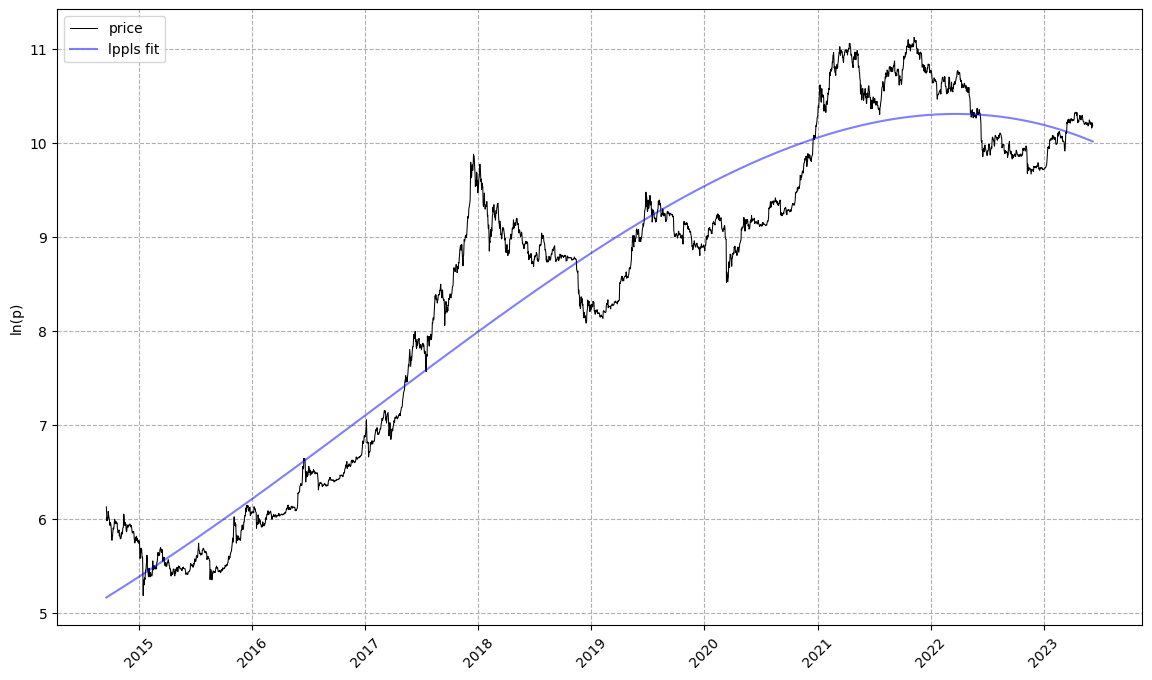

In [4]:
time = [pd.Timestamp.toordinal(dt.strptime(t1, '%Y-%m-%d')) for t1 in data['Date']]
price = np.log(data['Adj Close'].values)
observations = np.array([time, price])
MAX_SEARCHES = 25
lppls_model = LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)
lppls_model.plot_fit()

100%|██████████| 3068/3068 [1:15:12<00:00,  1.47s/it]


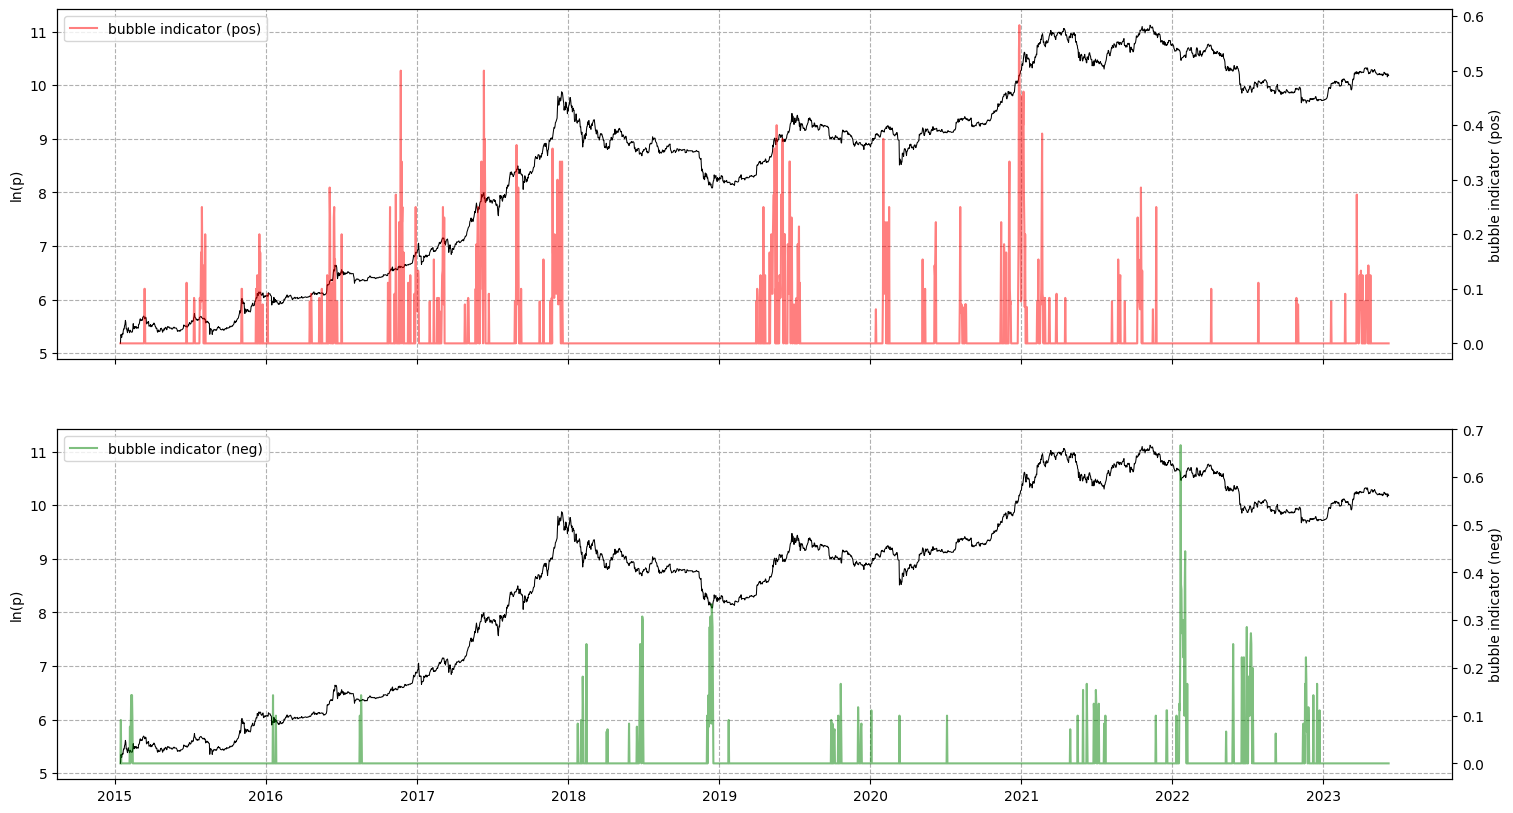

In [5]:
# compute the confidence indicator
res = lppls_model.mp_compute_nested_fits(
    workers=8,
    window_size=120, 
    smallest_window_size=30, 
    outer_increment=1, 
    inner_increment=5, 
    max_searches=25,
    # filter_conditions_config={} # not implemented in 0.6.x
)

lppls_model.plot_confidence_indicators(res)
# should give a plot like the following..